# Initial Thoughts


#### have following variables

#### Age - continuous
#### Acid Level - continuous
#### x ray res - binary
#### tumour size - binary
#### tumour grade - binary

 Predict nodal involvement - binary = logistic regression


Do boxplots of age, acid level vs nodal involvement, 
Observe interaction plots and some more?

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# from scipy.stats import pearsonr


In [3]:
df = pd.read_csv('data.csv')
df.head()


,Patient,Age,AcidLevel,XRayResult,TumourSize,TumourGrade,NodalInvolvement
0,1,66,0.48,0,0,0,0
1,2,68,0.56,0,0,0,0
2,3,66,0.50,0,0,0,0
3,4,56,0.52,0,0,0,0
4,5,58,0.50,0,0,0,0


In [74]:
# Break into Predictor / Response
X = df[['Age', 'AcidLevel', 'XRayResult', 'TumourSize', 'TumourGrade']]
y = df[['NodalInvolvement']]

In [5]:
# checking to see if any are equivalent -- not
filteredA = df[df['TumourGrade'] == df['XRayResult']]
filteredB = df[df['TumourGrade'] == df['TumourSize']]
filteredC = df[df['TumourSize'] == df['XRayResult']]

print(len(filteredA), len(filteredB), len(filteredC), len(df))

34 36 31 53


9


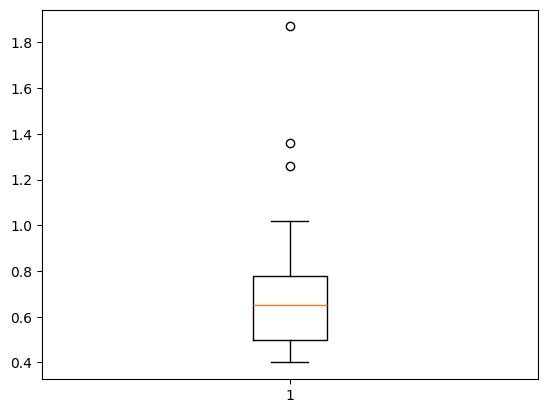

In [32]:
#Boxplot of AcidLevel Variable

plt.boxplot(x=df['AcidLevel'])

positive_xray_count = len(df[(df['XRayResult'] == 1)])
print(positive_xray_count)

In [6]:
# EDA - Main Terms Tabulation

# Nodal involvement breakdown by tumor size
size_involvement_tab = pd.crosstab(df['TumourSize'], df['NodalInvolvement'], margins=True, normalize='all')
print(size_involvement_tab, '\n')

# Nodal involvement breakdown by tumor grade
grade_involvement_tab = pd.crosstab(df['TumourGrade'], df['NodalInvolvement'], margins=True, normalize='all')
print(grade_involvement_tab, '\n')

# Nodal involvement breakdown by XRay result
xray_involvement_tab = pd.crosstab(df['XRayResult'], df['NodalInvolvement'], margins=True, normalize='all')
print(xray_involvement_tab, '\n')

# all of these seem to affect NodalInvolvement at first inspection



NodalInvolvement         0         1       All
TumourSize                                    
0                 0.396226  0.094340  0.490566
1                 0.226415  0.283019  0.509434
All               0.622642  0.377358  1.000000 

NodalInvolvement         0         1       All
TumourGrade                                   
0                 0.452830  0.169811  0.622642
1                 0.169811  0.207547  0.377358
All               0.622642  0.377358  1.000000 

NodalInvolvement         0         1       All
XRayResult                                    
0                 0.547170  0.169811  0.716981
1                 0.075472  0.207547  0.283019
All               0.622642  0.377358  1.000000 



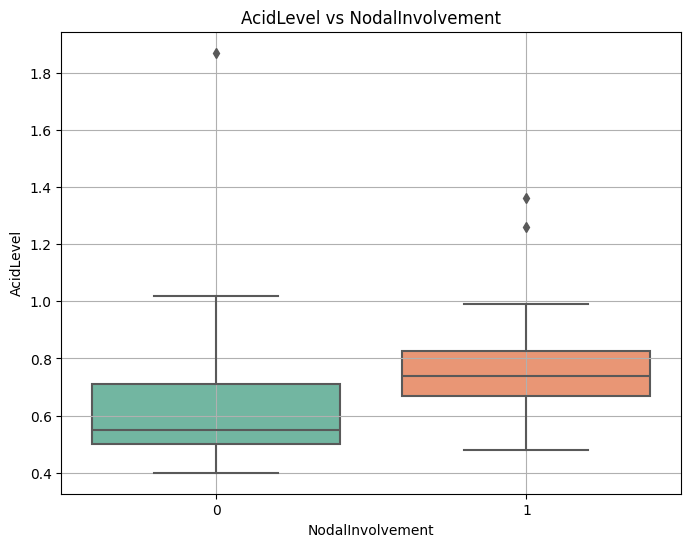

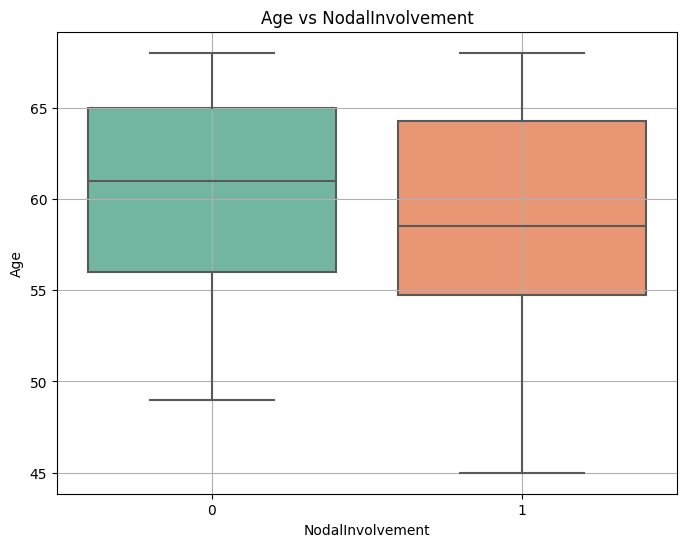

In [7]:
# EDA - Main Terms Boxplots

# Nodal involvement by acid level
# Side by side boxplot for acid level distributions in nodal_involvement = 1, 0
# Boxplot suggests difference in means, t-test?
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='NodalInvolvement', y='AcidLevel', palette='Set2')
plt.title('AcidLevel vs NodalInvolvement')
plt.xlabel('NodalInvolvement')
plt.ylabel('AcidLevel')
# plt.legend(title='Gender', loc='upper left')
plt.grid(True)
plt.show()

# Nodal Involvement by age
# Looks very similar, likely not helpful as a main term
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='NodalInvolvement', y='Age', palette='Set2')
plt.title('Age vs NodalInvolvement')
plt.xlabel('NodalInvolvement')
plt.ylabel('Age')
# plt.legend(title='Gender', loc='upper left')
plt.grid(True)
plt.show()



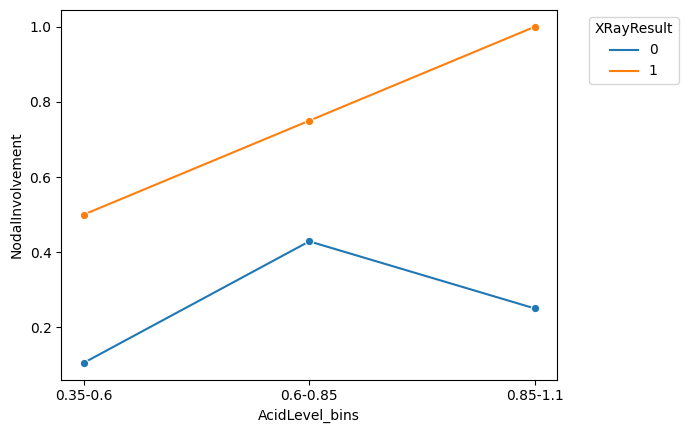

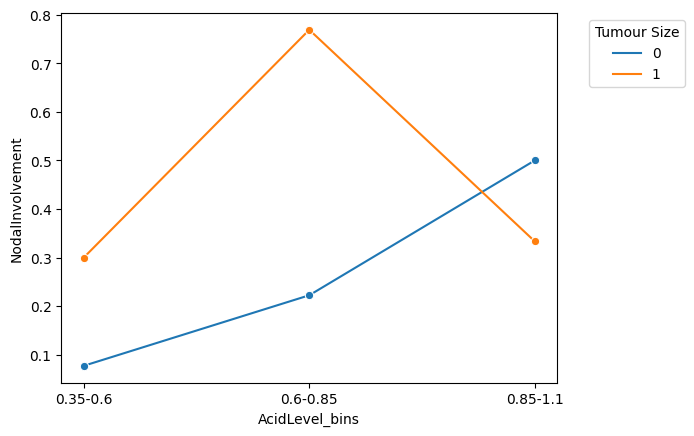

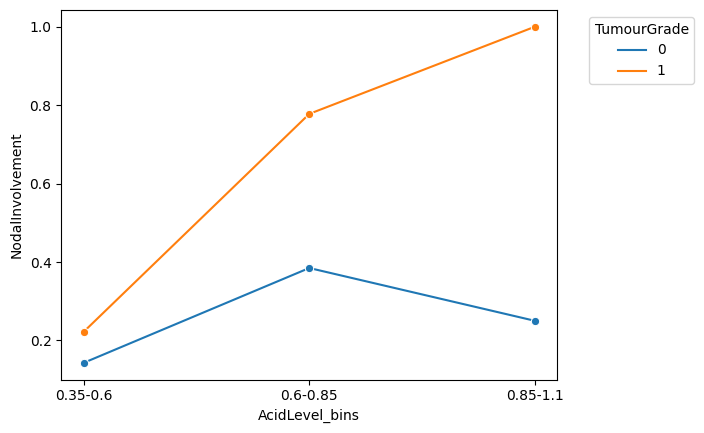

In [57]:
# EDA - Interaction Terms LinePlots of AcidLevel

# plt.figure(figsize=(8, 6))
# sns.boxplot(data=df, x='NodalInvolvement', y='AcidLevel', hue='XRayResult', palette='Set2')
# plt.title('AcidLevel vs NodalInvolvement')
# plt.xlabel('NodalInvolvement')
# plt.ylabel('AcidLevel')
# # plt.legend(title='Gender', loc='upper left')
# plt.grid(True)
# plt.show()


# Want to break acidlevel into bins, and calculate mean nodalinv rate for each bin / xrayresult combo, and then plot
bins = np.linspace(0.35, 1.1, 4)
df['AcidLevel_bins'] = pd.cut(df['AcidLevel'], bins=bins, labels=['0.35-0.6', '0.6-0.85', '0.85-1.1'])

mean_nodal_involvement_xray = df.groupby(['AcidLevel_bins', 'XRayResult'])['NodalInvolvement'].mean().reset_index()
mean_nodal_involvement_tsize = df.groupby(['AcidLevel_bins', 'TumourSize'])['NodalInvolvement'].mean().reset_index()
mean_nodal_involvement_tgrade = df.groupby(['AcidLevel_bins', 'TumourGrade'])['NodalInvolvement'].mean().reset_index()


# print(mean_nodal_involvement.head())
sns.lineplot(x='AcidLevel_bins', y='NodalInvolvement', hue='XRayResult', marker='o', data=mean_nodal_involvement_xray)
plt.legend(title='XRayResult', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

sns.lineplot(x='AcidLevel_bins', y='NodalInvolvement', hue='TumourSize', marker='o', data=mean_nodal_involvement_tsize)
plt.legend(title='Tumour Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

sns.lineplot(x='AcidLevel_bins', y='NodalInvolvement', hue='TumourGrade', marker='o', data=mean_nodal_involvement_tgrade)
plt.legend(title='TumourGrade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# From plot, AcidLevel:XRayResult appears a useful interaction term.
#  also AcidLevel:TumourGrade and AcidLevel:TumourSize appear worth trying in model.




In [63]:
# AcidLevel VS Age interaction
sns.relplot(x='AcidLevel', y='Age', hue='NodalInvolvement', data=df, kind='scatter')


AttributeError: module 'seaborn' has no attribute 'interactplot'

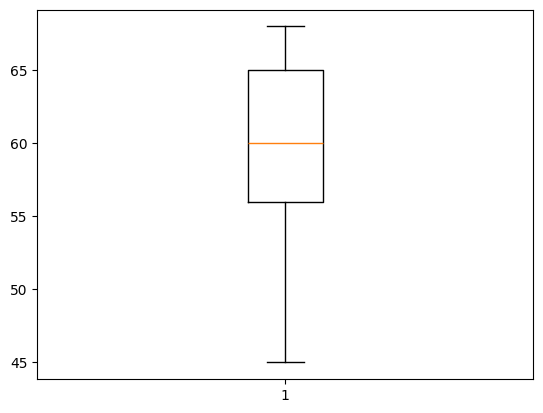

In [65]:
#AGE Distribution
plt.boxplot(df['Age'])
plt.show()

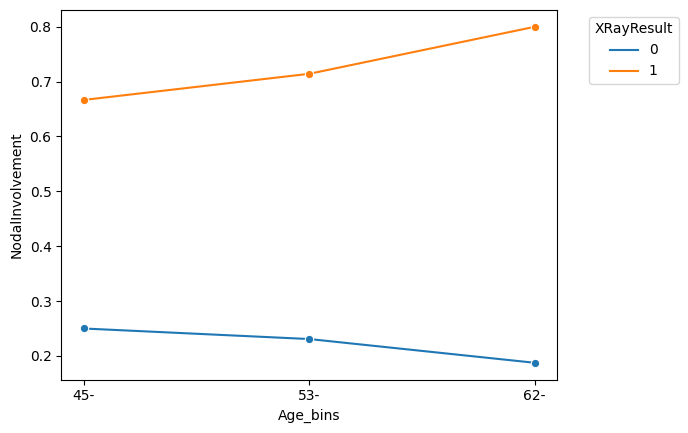

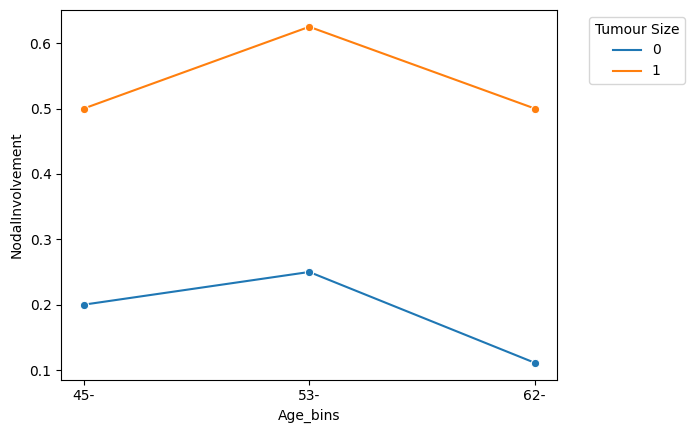

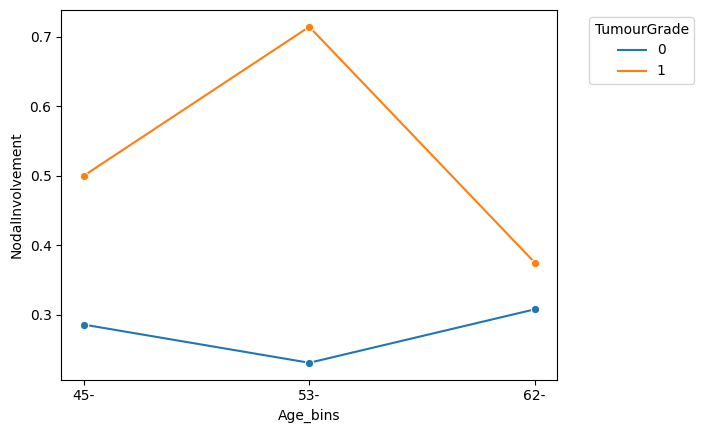

In [71]:
#Age vs Xray / Tumour binaries
bins = np.linspace(45, 70, 4)
df['Age_bins'] = pd.cut(df['Age'], bins=bins, labels=['45-', '53-', '62-'])

mean_nodal_involvement_xray = df.groupby(['Age_bins', 'XRayResult'])['NodalInvolvement'].mean().reset_index()
mean_nodal_involvement_tsize = df.groupby(['Age_bins', 'TumourSize'])['NodalInvolvement'].mean().reset_index()
mean_nodal_involvement_tgrade = df.groupby(['Age_bins', 'TumourGrade'])['NodalInvolvement'].mean().reset_index()


# print(mean_nodal_involvement.head())
sns.lineplot(x='Age_bins', y='NodalInvolvement', hue='XRayResult', marker='o', data=mean_nodal_involvement_xray)
plt.legend(title='XRayResult', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

sns.lineplot(x='Age_bins', y='NodalInvolvement', hue='TumourSize', marker='o', data=mean_nodal_involvement_tsize)
plt.legend(title='Tumour Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

sns.lineplot(x='Age_bins', y='NodalInvolvement', hue='TumourGrade', marker='o', data=mean_nodal_involvement_tgrade)
plt.legend(title='TumourGrade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


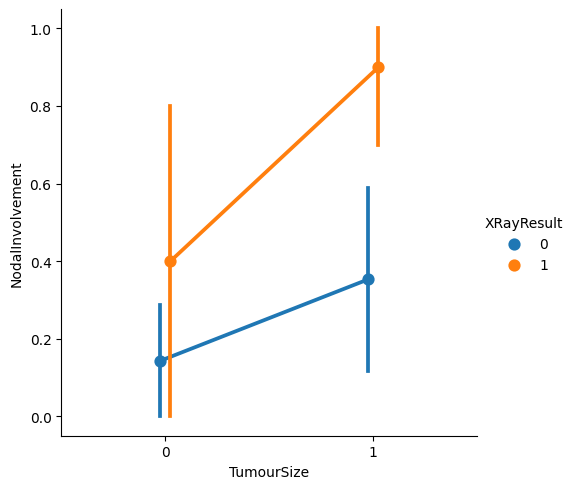

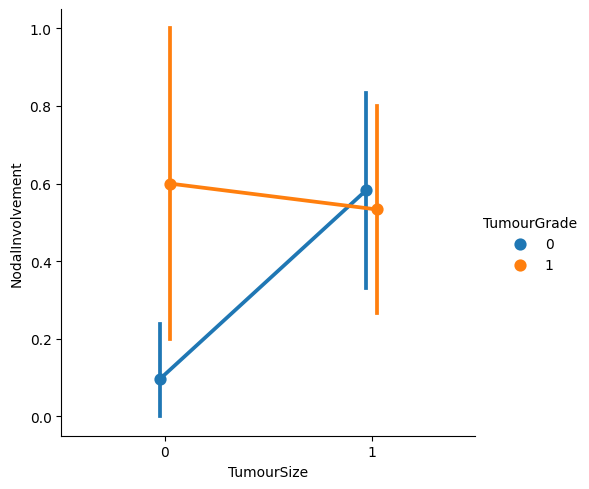

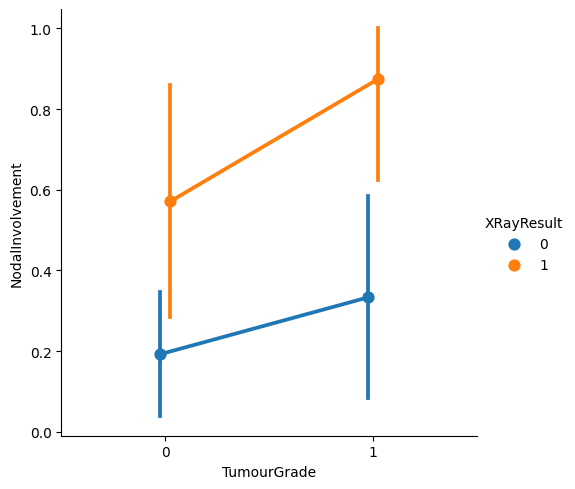

In [48]:
# Interaction Term Plots for Categorical vars


sns.catplot(x='TumourSize', y='NodalInvolvement', hue='XRayResult', kind='point', data=df, dodge=True)
plt.show()
sns.catplot(x='TumourSize', y='NodalInvolvement', hue='TumourGrade', kind='point', data=df, dodge=True)
plt.show()
sns.catplot(x='TumourGrade', y='NodalInvolvement', hue='XRayResult', kind='point', data=df, dodge=True)
plt.show()

#TumourSize:XRayResult and TumourSize:TumourGrade appear useful.

In [8]:
# Fit naive model:
naive_model = sm.Logit(y, sm.add_constant(X)).fit()
print(naive_model.summary())



Optimization terminated successfully.
         Current function value: 0.454017
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       NodalInvolvement   No. Observations:                   53
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                            5
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                  0.3150
Time:                        09:36:40   Log-Likelihood:                -24.063
converged:                       True   LL-Null:                       -35.126
Covariance Type:            nonrobust   LLR p-value:                 0.0004954
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0618      3.460      0.018      0.986      -6.720       6.843
Age            -0.0693    

In [83]:
# From plot, AcidLevel:XRayResult appears a useful interaction term.
#  also AcidLevel:TumourGrade and AcidLevel:TumourSize appear worth trying in model.
#TumourSize:XRayResult and TumourSize:TumourGrade appear useful.

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Fit and transform the DataFrame
interaction_terms = poly.fit_transform(X)
interaction_df = pd.DataFrame(interaction_terms, columns=poly.get_feature_names_out(input_features=X.columns))

# 'AcidLevel TumourGrade', 'AcidLevel XRayResult', 'AcidLevel TumourSize', 'XRayResult TumourSize', 'TumourSize TumourGrade'
initial_interaction = interaction_df[['Age', 'AcidLevel', 'TumourGrade', 'TumourSize', 'XRayResult', 'TumourSize TumourGrade','Age TumourGrade']]

X_train, X_test, y_train, y_test = train_test_split(initial_interaction, y, test_size=0.2)


initial_interaction_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(initial_interaction_model.summary())

X_test = sm.add_constant(X_test)
y_pred = initial_interaction_model.predict(X_test)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
print("Model accuracy:", accuracy)


Optimization terminated successfully.
         Current function value: 0.394926
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       NodalInvolvement   No. Observations:                   42
Model:                          Logit   Df Residuals:                       34
Method:                           MLE   Df Model:                            7
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                  0.4057
Time:                        23:02:17   Log-Likelihood:                -16.587
converged:                       True   LL-Null:                       -27.910
Covariance Type:            nonrobust   LLR p-value:                  0.001964
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -10.1460      9.211     -1.102      0.271     -28.199      